# Trabalho avaliativo - Sistemas de controle II - 2023.2

**Leia com atenção as instruções abaixo**

*Informe na célula de código abaixo o seu número de matrícula:* 

***Não remova as aspas***

In [1]:
# Informe aqui sua matrícula
mat = '202033940003'

*Depois de informar os dados, execute o arquivo inteiro. Caso ocorra algum erro, peça ajuda ao professor*

*Resolva as questões abaixo, **justificando** todas as respostas. Utilize markdown para escrever texto e Python para fazer as contas. O trabalho é individual*

In [2]:
# 
# Não modifique esta célula! Você pode comprometer a sua avaliação.
from numpy.random import RandomState
from IPython.display import display, Math
from sympy import symbols, sin, cos, latex
from sympy import ImmutableMatrix as matriz
from numpy import arange

_nn = int(mat[0:4]+mat[-2:])
_rng = RandomState(_nn)
#_dig = arange(-9,10)
#_dig = _dig[_dig!=0]
#_n = _rng.randint(0,_dig.size,20)
_n = _rng.random(size=(4,)).round(3)
def G(): 
    s = symbols('s')
    c = .5+0.10*_n[0]
    d = .5+0.25*_n[1]
    a = .2+0.15*_n[2]
    b = 9+_n[3]
    b0 = (b*c**2*d).round(3)
    b1 = (a*b*c**2*d).round(3)
    G = (b1*s+b0)/((s+c)**2*(s+d))
    display(Math('G(s) = ' + latex(G)))

In [3]:
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import control as ct
import scipy.signal as sig
from escrever import *
esc = escrever()

## 1.

*Considere o sistema:*

In [4]:
G()

<IPython.core.display.Math object>

1. *Faça uma análise de malha aberta: verifique estabilidade e características de resposta ao degrau unitário (25%). Opcional: analise o que aconteceria caso fosse utilizada realimentação proporcional (+10% extra)*

Primeiramente vamos calcular os polos para assim motarmos a função de espaço estados, como eu observei que o sistema tinha polos iguais, resolvi usar a forma de Jordan com polos reais e repetidos.

In [5]:
# Calcula resíduos e pólos
import numpy as np

num = np.array([0.449,1.97])

# As duas próximas calculam o denominador
den = np.convolve([1,0.5395],[1,0.5395])
den = np.convolve(den,[1,0.7])

# Acha os resíduos. 
r,p,k = sig.residue(num,den)
print('Resíduos: ', r)
print('Pólos: ',p)

Resíduos:  [-64.27344455  10.76488785  64.27344455]
Pólos:  [-0.5395 -0.5395 -0.7   ]


$$
\begin{align*}
    \dot{x}_1  &= u -0.5395x_1\\
    \dot{x}_2 &= x_1 -0.5395x_2\\
    \dot{x}_3 &= u -0.7x_3\\
    \mathbf{y} &= -64.27344455x_1 + 10.76488785x_2 + 64.27344455x_3\\
\end{align*}
$$

Aqui encontraremos as matrizes de F, G, H, e I

In [6]:
F = np.matrix([[-0.5395,0,0],[1,-0.5395,0],[0,0,-0.7]])
G = np.matrix([1,0,1]).T
H = np.matrix([-64.27344455,10.76488785,64.27344455])
D = np.matrix([0])

sys = ct.ss(F,G,H,0)
esc.sist(F,G,H,D)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [7]:
damp_info = ct.damp(sys)

_____Eigenvalue______ Damping___ Frequency_
   -0.5395                     1     0.5395
   -0.5395                     1     0.5395
      -0.7                     1        0.7


encontrando os autovalores, saberemos se o sistema é estável ou não, mas também dá de saber olhando os polos, caso os polos sejam positivos ou seja esteja no semi-plano direito, então ele será instável

In [8]:
A = np.array([[-0.5395,0,0],[1,-0.5395,0],[0,0,-0.7]])
s,v = np.linalg.eig(A)
print("Autovalores: ")
print(s.round(decimals=4))

Autovalores: 
[-0.5395 -0.5395 -0.7   ]


Como podemos ver os autovalores são reais negativos e isso significa que eles são estáveis

In [40]:
#zero do sistema
ct.zeros(sys)

array([-4.38752784+0.j])

Aqui mostramos o sistema respondendo a um degral unitário, e pelo gráfico dá de ver que ele demora a subir e se acomodar, da de perceber também que não tem overshoot.

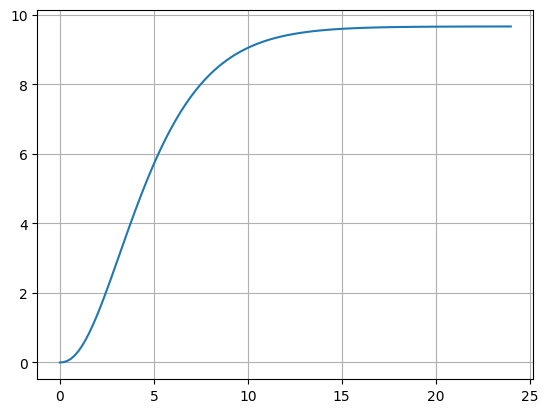

In [41]:
t,y = ct.step_response(sys,24)
plt.plot(t,y)
plt.grid()
plt.show()

2. *Proponha especificações de desempenho em malha fechada com base na análise de malha aberta do item 1 (20%).*

In [11]:
ct.step_info(sys)

{'RiseTime': 7.242663813725759,
 'SettlingTime': 12.803994956408038,
 'SettlingMin': 8.713270240227672,
 'SettlingMax': 9.669082995588099,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 9.483988310476207,
 'PeakTime': 12.803994956408038,
 'SteadyStateValue': 9.669082995588099}

observando os dados que nos foram mostrados pela função ct.step_info, podemos perceber que seu tempo de subida não está muito desejável, por isso queremos diminuir, quanto menor o seu valor, mais rápido será a resposta do sistema, temos também o tempo de acomodamento, o overshoot e entre outros, mas devemos estar ciente que quando mudamos um desses valores, os outros também mudam, temos que tentar equilibrar na hora de escolher os valores dos parâmetros.

Escolhi um valor de tempo de acomodamento como 3.65s, e uma frequência natural de 1.2, a partir desses dois valores, vamos encontrar o valor de overshoot, instante de pico, amortecimento e tempo de subida.

In [33]:
Ts = 3.65
wn = 1.2
xi = (4)/(wn*Ts)
Tp = (np.pi)/(wn*(np.sqrt(1-(xi)**2)))
Tr = (1.8)/(wn*(np.sqrt(1-(xi)**2)))
c10 = (-xi*np.pi)
c11 = np.sqrt(1-((xi)**2))
Up = 100* (np.exp(c10/c11))
print("Amortecimento:", xi)
print("Instante de pico:", Tp)
print("Tempo de subida:", Tr)
print("Overshoot:", Up)

Amortecimento: 0.9132420091324202
Instante de pico: 6.425825527690618
Tempo de subida: 3.681726826240975
Overshoot: 0.08743755545755282


analisando os resultados, o overshoot está muito bom ele está bem próximo de zero ele quase não ultrapassa o valor desejado, o tempo de subida também está bom contando com apenas 3,68 segundos, antes era 12,80 quase 4 vezes maior que o valor atual, já o seu amortecimento é quase criticamente amortecido, pois o seu amortecimento é quase 1, então não haverá tanta oscilação.





3. *Projete um compensador de estados de ordem completa, de acordo com as especificações estabelecidas no item 2 e também forneça rejeição à distúrbios do tipo degrau. Justifique as escolhas de todos os pólos e apresente as funções de transferência do compensador ao final (35%).*

Inicialmente para projetar um compensador de ordem completa, é necessário primeiro estabelecer os requisistos de desempenho, como tempo de subida, amortecimento, frequência natural, overshoot e outros, e tudo isso foi estabelecido na questão 2, depois projetar os polos desejados, afinal são eles que determinam a estabilidade e resposta transitória.

In [13]:
p = -xi*wn+1j*wn*np.sqrt(1-xi**2)
esc.polos(xi,wn)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Encontrar os polos reguladores, que são compostos por polos dominantes e polos extras, dependendo de onde a gente colocar esses polos podemos deixar o sistema mais rápido, estável e menos oscilante.

In [14]:
polos_dom = np.array([[p, np.conjugate(p)]])
polos_extras = np.array([[np.real(p)*4]*2])
polos_re = np.block([polos_dom,polos_extras])
display(Math(esc.mat(polos_re.T.round(decimals=4))))



<IPython.core.display.Math object>

Como o número de polos aumentou, então precisamos ir para o próximo passo que seria a construção de uma matriz aumentada, antes era uma matriz 3x3, mas como o número de polos aumentou para 4, então a matriz aumentada serar de 4x4, para realizar a contrução da matriz aumentada, pegaremos a matriz F e colocamos uma coluna a mais, na coluna 4 colocamos um vetor composto de zeros, e pomos uma linha a mais na linha 4 colocamos o vetor H.


$$
\begin{align*}
    \begin{bmatrix}
    F_{11} & F_{12} & F_{13} & 0\\
     F_{21} & F_{22} & F_{23} & 0\\
     F_{31} & F_{32} & F_{33} & 0\\
     H_{41} & H_{42} & H_{43} & 0\\
    \end{bmatrix}
\end{align*}
$$


In [42]:
#matriz aumentada
Fa = np.block([[F,np.zeros((3,1))],[-H, 0]])
Ga = np.block([[G],[0]])
Fa

matrix([[ -0.5395    ,   0.        ,   0.        ,   0.        ],
        [  1.        ,  -0.5395    ,   0.        ,   0.        ],
        [  0.        ,   0.        ,  -0.7       ,   0.        ],
        [ 64.27344455, -10.76488785, -64.27344455,   0.        ]])

Agora vamos encontrar o ganho do controlador ou ganho do regulador, que é responsável pela velocidade da resposta do sistema, porém um ganho muito alto pode causar instailidade e oscilações no sitema.

In [16]:
Ka = ct.acker(Fa,Ga,polos_re[0,:])
display(Math(r'\mathbf{K}_a = ' + esc.mat(Ka.round(4))))

<IPython.core.display.Math object>

Agora vamos encontrar o estimador, esse estimador ele é tipo um sistema que tenta copiar o original, corrigindo as estimativas quando o sinal de saída mostra que tem alguma diferença.


In [17]:
i = 7
polo_est1 = np.array([[p*i, np.conjugate(p)*i]])
polo_est2 = np.array([[np.real(p)*i*4]])
polos_estimador = np.block([polo_est1,polo_est2])
display(Math(esc.mat(polos_estimador.T.round(decimals=4))))

<IPython.core.display.Math object>

Vamos determinar o valor do ganho do estimador, ele significa um ajuste que controla o quanto as medições são importantess, se for muito alta então tem muita importância, caso contrário, então seria de menor importância, essas medições são as informações sobre o comportamento real do sistema.

In [18]:
L = ct.acker(F.T,H.T,polos_estimador[0,:]).T
display(Math(r'\mathbf{L} = ' + esc.mat(L.round(4))))

<IPython.core.display.Math object>

In [19]:
# Montagem do controlador e função de transferência
Fl = np.block([[F,np.zeros((3,1))],[np.zeros((1,4))]])
Gl = Ga
Hl = np.block([H,0])
L0 = np.block([[L],[0]])
L1 = np.block([[L],[-1]])
M = np.block([[np.zeros((3,1))],[1]])
Fc = Fl-Gl@Ka-L0@Hl
Gc = np.block([L1,M])
Hc = -Ka
Ic = np.zeros((1,2))
esc.sist(Fc.round(4),Gc.round(4),Hc.round(4),Ic)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

E para finalizar temos aqui a função de transferência.

In [20]:
# Funções de transf.
COC_1 = ct.ss(Fc,Gc[:,0],Hc,Ic[:,0])
COC_1 = ct.tf(COC_1)
COC_2 = ct.ss(Fc,Gc[:,1],Hc,Ic[:,1])
COC_2 = ct.tf(COC_2)
display(COC_1)
display(COC_2)

TransferFunction(array([-10747.10878256, -43841.7983605 , -60489.14345587, -30411.24896036]), array([1.00000000e+00, 5.52073014e+01, 9.86363419e+02, 3.34939641e+03,
       0.00000000e+00]))

TransferFunction(array([1.40459301e+01, 6.46497604e+02, 7.60365904e+03, 3.04112475e+04]), array([1.00000000e+00, 5.52073014e+01, 9.86363419e+02, 3.34939641e+03,
       0.00000000e+00]))

4. *Analise e simule o sistema em malha fechada. Plote e analise os sinais de saída e de controle (20%). Opcional: faça uma análise de resposta a uma perturbação (+10% extra)*

In [21]:
# Analisa o sistema em malha fechada
Fmf = np.block([[F,-G@Ka],[L1@H,Fl-Gl@Ka-L0@Hl]])
Gmf = np.block([[np.zeros((F.shape[0],1))],[M]])
Hmf = np.block([H,np.zeros((Hl.shape))])
Imf = np.zeros((Hmf.shape[0],Gmf.shape[1]))
MF = ct.ss(Fmf,Gmf,Hmf,Imf)
esc.sist(Fmf.round(4),Gmf.round(4),Hmf.round(4),Imf)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [22]:
# Relatório de polos
tab=ct.damp(MF)
print('Projeto regulador:', polos_re)
print('Projeto estimador' , polos_estimador)
print('Zeros:', MF.zeros())

_____Eigenvalue______ Damping___ Frequency_
    -30.68                     1      30.68
    -7.671    +3.422j     0.9132        8.4
    -7.671    -3.422j     0.9132        8.4
    -4.384 +0.004402j          1      4.384
    -4.384 -0.004402j          1      4.384
    -1.096   +0.4889j     0.9132        1.2
    -1.096   -0.4889j     0.9132        1.2
Projeto regulador: [[-1.09589041+0.48890102j -1.09589041-0.48890102j -4.38356164+0.j
  -4.38356164+0.j        ]]
Projeto observador [[ -7.67123288+3.42230714j  -7.67123288-3.42230714j
  -30.68493151+0.j        ]]
Zeros: [-30.68493144+0.j          -7.67123291+3.42230709j
  -7.67123291-3.42230709j  -4.38752784+0.j        ]


Aqui foi nos mostrado as informações dos polos, frequências e zeros, e como podemos ver os zeros estão se cancelando com os polos, pois mesmo que seja feita várias realimentações, os zeros não mudam, só podem ser cancelados com os polos de mesmo valor desses zeros, e foi isso que eu fiz, eu fiz algumas modificações principalmente nos polos regulares para que conseguissem se cancelar, ja os polos estimados conseguiram cancelar os zeros de primeira, então não precisei mexer neles. Esse cancelamento dos zeros é necessário para eles não causarem problemas ao sistema como oscilações ou instabilidade.

In [23]:
# Simulação de estado inicial
resp = ct.step_response(MF,15)

In [24]:
# Cálculo do sinal de controle
u = -Ka@resp.states[3:,:]

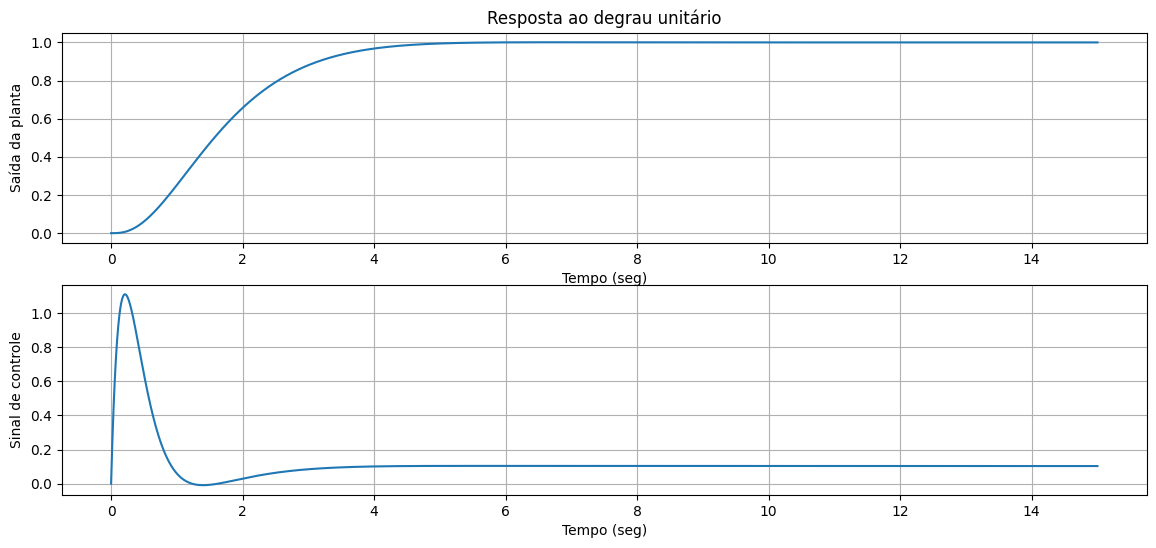

In [25]:
from matplotlib import pyplot as plt
# Plotagem da resposta
plt.figure(figsize=(14,6))
plt.subplot(211)
plt.plot(resp.t,resp.outputs)
plt.xlabel('Tempo (seg)')
plt.ylabel('Saída da planta')
plt.title('Resposta ao degrau unitário')
plt.grid()
# Calcula e plota o sinal de controle
plt.subplot(212)
plt.plot(resp.t,u.T)
plt.xlabel('Tempo (seg)')
plt.ylabel('Sinal de controle')
plt.grid()

Vamos tentar interpretar um pouco esses dois gráficos, no primeiro mostra a saída da planta que tem uma demora para subir e se acomodar, mas com a realimentação vai conseguir diminuir esses dois valores e na saída teremos os dois valores de subida e acomodação menores como mostra no segundo gráfico, como nessa segunda situação o sistema está mais rápio e tem overshoot, porque ele tenta ir tão rápido que passa o desejado, mas depois volta para o lugar certo até entrar em regime permanente, já o primeiro, não tem overshoot, mas fica o sistema lerdo.

considerações finais: é importante saber a utilidade do compensador de estado de ordem completa, pois ele tenta melhorar o sistema, o deixando mais rápido, tentando lhe deixar estável, melhorando o desenpenho, ele permite que haja o controle de várias variaveis de controle e considerando suas interações e influências mútuas. ele consegue fazer isso usando informações internas do sistema para fazer algumas correções para deixa tudo funcionando do jeito desejável,usando um exemplo, ele é como um supervisor que fica de olho na empresa onde trabalha para que tudo ocorra de forma organizada e melhorada.